# ======================== Library ============================

In [1]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary

from PIL import Image
import scipy.io as sio
import numpy as np
import os

import skimage.measure
import pickle
import numpy, scipy.io

from sklearn.metrics import precision_recall_curve,auc
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

# ======================== Functions ============================

In [2]:
def read_files():
    # Upload the data 
    return image_train, image_test, label_train, label_test

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1    = nn.Conv2d(3, 32, kernel_size=3)
        self.conv1_Bn = nn.BatchNorm2d(32)
        self.relu_1     = nn.ReLU()
        
        self.conv2    = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_Bn = nn.BatchNorm2d(64)
        self.relu_2     = nn.ReLU()
        
        self.conv3     = nn.Conv2d(64, 64, kernel_size=3)
        self.conv3_Bn  = nn.BatchNorm2d(64)
        self.relu_3    = nn.ReLU()
        
        self.conv4     = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4_Bn  = nn.BatchNorm2d(128)
        self.relu_4    = nn.ReLU()
        
        self.conv5    = nn.Conv2d(128, 256, kernel_size=3)
        self.conv5_Bn = nn.BatchNorm2d(256)
        self.relu_5   = nn.ReLU()
        
        self.fc1 = nn.Linear(2304,128)
        self.fc2 = nn.Linear(128,10)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu_1(x)
        x = self.conv1_Bn(x)
        x = F.max_pool2d(x,2)
        
        x = self.conv2(x)
        x = self.relu_2(x)
        x = self.conv2_Bn(x)
        
        x = self.conv3(x)
        x = self.relu_3(x)
        x = self.conv3_Bn(x)
        x = F.max_pool2d(x,2)
        
        x = self.conv4(x)
        x = self.relu_4(x)
        x = self.conv4_Bn(x)
        x = F.max_pool2d(x,2)
        
        x = self.conv5(x)
        x = self.relu_5(x)
        x = self.conv5_Bn(x)
        
        #print(x.shape)
        x = x.view(-1,2304)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(x,dim=1)
        
        return x

In [5]:
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in model._modules.items():
            if isinstance(module, torch.nn.modules.activation.ReLU):
                print(pos)
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        input_image  = input_image.to(device)
        self.model   = self.model.to(device)
        model_output = self.model(input_image)
        
        # Target for backprop
        one_hot_output                  = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        one_hot_output                  = one_hot_output.to(device)
        
        # Backward pass
        self.model.zero_grad()
        model_output.backward(gradient=one_hot_output)
        
        #convert to numpy
        gradients   = self.gradients.cpu()
        gradients_as_arr = gradients.data.numpy()[0]
        return gradients_as_arr

In [126]:
def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize
    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    
    pos_saliency = np.moveaxis(pos_saliency,0,2)
    neg_saliency = np.moveaxis(neg_saliency,0,2)
    return pos_saliency, neg_saliency

# ===================== upload model ==========================

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = torch.load(r"models\model.pth").to(device)
model.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_Bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_Bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_2): ReLU()
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3_Bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_3): ReLU()
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4_Bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_4): ReLU()
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5_Bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_5): ReLU()
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=Tru

# ====================== Upload data ========================

In [7]:
image_train, image_test, label_train, label_test = read_files()

In [9]:
image_train  = np.stack(image_train,axis=0)
image_test   = np.stack(image_test,axis=0)
label_train  = np.stack(label_train,axis=0)
label_test   = np.stack(label_test,axis=0)

In [10]:
image_train = np.array(image_train).astype('float32')
image_test  = np.array(image_test).astype('float32')

image_train = np.moveaxis(image_train,-1,1)
image_test  = np.moveaxis(image_test,-1,1)

image_train = torch.from_numpy(image_train / 255.0)
image_test  = torch.from_numpy(image_test / 255.0)
label_train = torch.from_numpy(label_train)
label_test  = torch.from_numpy(label_test)

# ==================== Plot original image =====================

In [ ]:
ind = 4500
original_image = image_train[ind]
target_class   = label_train[ind]
plt.imshow(np.moveaxis(original_image.cpu().numpy(),0,2))

# ================ Compute Gradient decent  =====================

In [132]:
im_as_ten = original_image
im_as_ten.unsqueeze_(0)
prep_img = Variable(im_as_ten, requires_grad=True)

GBP = GuidedBackprop(model)
guided_grads = GBP.generate_gradients(prep_img, target_class)

relu_1
relu_2
relu_3
relu_4
relu_5


# ================= Plot original saliency map =====================

(64, 64, 3)


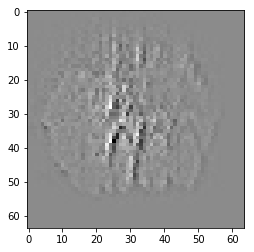

In [133]:
guided_grads_1 = np.moveaxis(guided_grads,0,2)
guided_grads_1 = (guided_grads_1 -guided_grads_1.min())/(guided_grads_1.max()-guided_grads_1.min())
print(guided_grads_1.shape)
plt.imshow(guided_grads_1)
plt.imshow(np.expand_dims(np.sum(guided_grads_1,axis=2),axis=2)[...,0],cmap="gray")

In [134]:
pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)

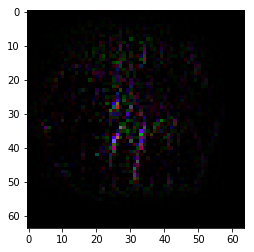

In [136]:
plt.imshow(neg_sal)

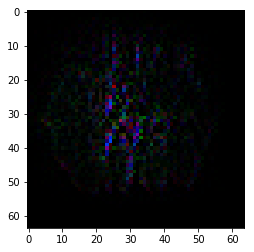

In [137]:
plt.imshow(pos_sal)